<a href="https://colab.research.google.com/github/Bandi120424/KDT-AI/blob/Month-2/House_Prices_Regreesion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 및 데이터 임포트

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

%matplotlib inline

In [88]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [89]:
train = train_data.copy()
test = test_data.copy()

## 데이터 구성 확인 및 결측치/이상치 처리

#### 데이터 구성 확인

In [90]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [92]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


#### 수치형 변수와 범주형 변수 탐색

In [93]:
numerical_feats = train.dtypes[train.dtypes !='object'].index
categorical_feats = train.dtypes[train.dtypes =='object'].index

print(f"numerical features: {len(numerical_feats)}, categorical features:  {len(categorical_feats)}")

numerical features: 38, categorical features:  43


In [94]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### IQR 방식을 이용하여 train의 수치형 변수 이상치 제거


In [95]:
class remove_outliers():
  def __init__(self, method = 'iqr', n = 2):
    self.method = method
    self.n = n


  def fit(self, X, y=None):
        return self

  def transform(self, X):
    features = X.dtypes[X.dtypes !='object'].index #수치형 변수 탐색
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(X[col], 25)
        Q3 = np.percentile(X[col], 75)
        outlier_step = 1.5*(Q3-Q1)
        
        outlier_list_col  = X[(X[col] > Q3+outlier_step) | (X[col] < Q1-outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices) #outlier_indices의 각 원소가 몇 번 나오는지를 담은 객체 반환 
    multiple_outlier_indices = list(k for k, v in outlier_indices.items() if v > self.n) #n번 이상 나오는 이상치를 제거
    new_X = X.drop(multiple_outlier_indices, axis = 0).reset_index(drop=True)
    return new_X

#### 결측치 처리

**결측치 처리 가이드라인**
- 10% 미만: 삭제 or 대치
- 10% - 50%: regression or model based imputation
- 50% 이상: 컬럼 자체 제거


train을 기반으로 결측치 처리 방법 구성 => class화

In [96]:
train_na = (train.isnull().sum()/len(train)) * 100
train_na = train_na.drop(train_na[(train_na == 0) | (train_na >= 50)].index).sort_values(ascending=False) 
train_na

FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

결측치 특성을 살펴보자. 

*   LotFrontage: Linear feet of street connected to property  
=> Neighborhood와 상관관계가 높을 것으로 추정  
=> Neighborhood를 기준으로 한 평균값으로 결측치를 채움 
*   나머지 특성들은 결측치의 비율이 크지 않으므로, NA나 0 값을 가질 수 있는 특성의 경우, NA나 0으로 채워줌  

  **이 때, Garage 관련 속성과 Basement 관련 속성 처리에 주의하자**  
  Garage/Basement가 없으면 관련 속성도 다 0나 Null로 처리

*   MSZoning, Utilities, Functional, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType, MSSubClass  
=> 위 특징들은 값을 NA로 채울 수 없으므로 최빈값으로 채워줌









In [97]:
class handle_missing_val():

  def fit(self, X, y=None):
        return self
        
  def transform(self, X):
    #NA값이 있는 특징
    feats_with_NA = ['LotFrontage', 'LotArea','YearRemodAdd',
       'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold']
    
    num_feats = X.dtypes[X.dtypes !='object'].index.tolist()
    cat_feats = X.dtypes[X.dtypes =='object'].index.tolist()

    #각 feature의 결측치 비율구함. 결측치 처리를 해줘야하는 feature 선택 
    missing_ratio_sr = (X.isnull().sum()/len(X)) * 100
    selected_feats = missing_ratio_sr.drop(missing_ratio_sr[(missing_ratio_sr == 0) | (missing_ratio_sr >= 50)].index).index.tolist()


    if 'LotFrontage' in selected_feats:
      X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    X[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = X[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].fillna(value=0)
    X[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = X[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna(value='NA')
    
    X[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] =  X[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('NA')
    X[['GarageYrBlt', 'GarageArea', 'GarageCars']] = X[['GarageYrBlt', 'GarageArea', 'GarageCars']].fillna(0)

    #NA값을 가지는 속성 NA 또는 0으로 채워줌
    num_selected_feats_with_NA = [a for a in selected_feats if a in feats_with_NA and a in num_feats]
    cat_selected_feats_with_NA = [a for a in selected_feats if a in feats_with_NA and a in cat_feats]
    X[num_selected_feats_with_NA] = X[num_selected_feats_with_NA].fillna(X[num_selected_feats_with_NA].fillna(0))
    X[cat_selected_feats_with_NA] = X[cat_selected_feats_with_NA].fillna(X[cat_selected_feats_with_NA].fillna('NA'))
    
    #NA값을 가지지 못하는 속성 최빈값으로 채움 
    selected_feats_with_no_NA = [a for a in selected_feats if a not in feats_with_NA]
    X[selected_feats_with_no_NA] = X[selected_feats_with_no_NA].fillna(X[selected_feats_with_no_NA].mode().iloc[0])

    return X

## 수치형 특성 분석

###  새로운 특징 생성 및 특성 타입 변경 (수치형 특성 -> 범주형 특성)  
MSSubClass, OverallCond, MoSold, YrSold은 수치형 특성이지만 범주형처럼 생각할 수 있는 특성이므로 범주형 특성으로 처리한다.


In [98]:
class create_features():

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X['Total_Home_Quality'] = X['OverallQual'] + X['OverallCond']
    X['Total_sqr_footage'] = (X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF'])
    X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) + X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
    X['Total_porch_sf'] = (X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
    X[['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']] = X[['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']].astype(str)
    return X

### 수치형 특성 정규화 처리

**첨도, 왜도**
- 첨도: 측정치의 빈도수의 분포 (정규분포는 첨도 0)
- 왜도: 분포의 비대칭성을 나타냄, 절댓값 3 미만까지는 왜도가 크지 않다고 판단

1. 첨도의 절댓값이 1 이상 OR 왜도의 절댓값이 3 이상인 특성 중, SalePrice (타깃값)과의 상관관계지수가 0.1 이상인 특성에 한해서 정규화 처리  
  **상관관계지수 절댓값이 0.1 이상인 특성**
['TotalBsmtSF', '1stFlrSF', 'GarageYrBlt', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr'] 
2. 정규화 후, |skew| >= 1 또는 |kurt| >= 3인 값은 특성에서 제거

In [99]:
class normalize_val_4_train():

  def fit(self, X, y=None):
        return self

  def transform(self, X):
    num_feats = list(X.dtypes[X.dtypes !='object'].index)
    num_feats = [a for a in num_feats if a not in ('Id', 'SalePrice')]

    #정규화할 특성 추출
    X_skew = X[num_feats].skew()
    X_kurt = X[num_feats].kurt()
    skew_list = X_skew[abs(X_skew) >= 1].index.tolist()
    kurt_list = X_kurt[abs(X_kurt) >= 3].index.tolist()

    tmp_feats = list(set(skew_list+kurt_list))

    #corr_data = X[tmp_feats+['SalePrice']].corr()
    #corr_feats = corr_data[abs(corr_data['SalePrice']) > 0.1].index.tolist() 
    corr_feats = ['TotalBsmtSF', '1stFlrSF', 'GarageYrBlt', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr']
    selected_feats = [a for a in tmp_feats if a in corr_feats]

    #정규화 수행
    X[selected_feats] = np.log1p(X[selected_feats])
    
    #|skew| >= 1 인 값은 특성에서 제거
    new_X_skew = X[num_feats].skew()
    del_feats1 = new_X_skew[abs(new_X_skew) >= 1].index.tolist()
    
    #|kurt| >= 3 인 값은 특성에서 제거
    new_X_kurt = X[num_feats].kurt()
    del_feats2 = new_X_kurt[abs(new_X_kurt) >= 3].index.tolist()
    
    del_feats = list(set(del_feats1 + del_feats2))
    X = X.drop(del_feats, axis = 1)

    return X

**train set 관찰을 통해 얻은 최종 수치형 특성**

final_num_feats = ['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
 'BsmtFullBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',  'Total_Home_Quality', 'Total_sqr_footage',
 'Total_Bathrooms', 'Total_porch_sf']

## 범주형 특성 분석

각 범주형 특성당 데이터 분포를 확인
=> 값이 현저히 치우쳐진 경우 훈련에서 제외

데이터 관찰을 통해 다음 특성을 제외

['Utilities', 'YrSold', 'LandSlope', 'LotConfig', 'Condition2', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'MoSold']

## 특성 조정
훈련에 사용할 특성에 대하여 다음을 수행
- 수치형 특성: 정규화
- 범주형 특성: 라벨인코딩

In [100]:
class modify_feats():

  def fit(self, X, y=None):
        return self

  def transform(self, X):
    num_feats = list(X.dtypes[X.dtypes != 'object'].index)
    final_num_feats =  ['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF', 'Total_Home_Quality', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']
    cat_feats = list(X.dtypes[X.dtypes == 'object'].index)
    del_feats = ['Utilities', 'YrSold', 'LandSlope', 'LotConfig', 'Condition2', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'MoSold']
    final_cat_feats = [a for a in cat_feats if a not in del_feats]

    #정규화 수행
    if 'SalePrice' in num_feats:
      final_num_feats += ['SalePrice']      
    X[final_num_feats] = np.log1p(X[final_num_feats])

    #라벨 인코딩 수행 
    le = LabelEncoder()
    new_X = X[final_cat_feats].apply(le.fit_transform)

    #훈련에 사용할 범주형 특성만 남김 
    X = X.drop(cat_feats, axis = 1)

    return pd.concat([X, new_X], axis = 1)  

In [101]:
pipe = make_pipeline(remove_outliers(), handle_missing_val(), create_features(), modify_feats())
train = pipe.fit_transform(train)

In [102]:
pipe_test = make_pipeline(handle_missing_val(), create_features(), modify_feats())
test = pipe_test.fit_transform(test)

In [103]:
test_na = (test.isnull().sum()/len(test)) * 100
test_na[test_na != 0]

Series([], dtype: float64)

### 훈련 

라이브러리 임포트

In [104]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [105]:
X_train = train.drop(['Id', 'SalePrice'], axis = 1).values
target_label = train['SalePrice'].values
X_test = test.drop('Id', axis = 1).values

In [106]:
print(f"train shape: {X_train.shape}")
print(f"target_label shape: {target_label.shape}")
print(f"test shape: {X_test.shape}")

train shape: (1326, 74)
target_label shape: (1326,)
test shape: (1459, 74)


In [107]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 42)

In [108]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [109]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## 평가

In [110]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [111]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y_pred):
    rmse = np.sqrt(-cross_val_score(model, X, y_pred, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

scores = {}

In [112]:
lasso.fit(X_tr, y_tr)
score = cv_rmse(lasso, X_tr, y_tr)
scores['lasso'] = (score.mean(), score.std())

ENet.fit(X_tr, y_tr)
score = cv_rmse(ENet, X_tr, y_tr)
scores['Elastic Net'] = (score.mean(), score.std())

GBoost.fit(X_tr, y_tr)
score = cv_rmse(GBoost, X_tr, y_tr)
scores['GBoost'] = (score.mean(), score.std())

averaged_models = AveragingModels(models = (lasso, ENet, GBoost))
averaged_models.fit(X_tr, y_tr)
score = cv_rmse(averaged_models, X_tr, y_tr)
scores['Average Model'] = (score.mean(), score.std())

model_xgb.fit(X_tr, y_tr)
score = cv_rmse(model_xgb, X_tr, y_tr)
scores['XGBRegressor'] = (score.mean(), score.std())

model_lgb.fit(X_tr, y_tr)
score = cv_rmse(model_lgb, X_tr, y_tr)
scores['LGBMRegressor'] = (score.mean(), score.std())

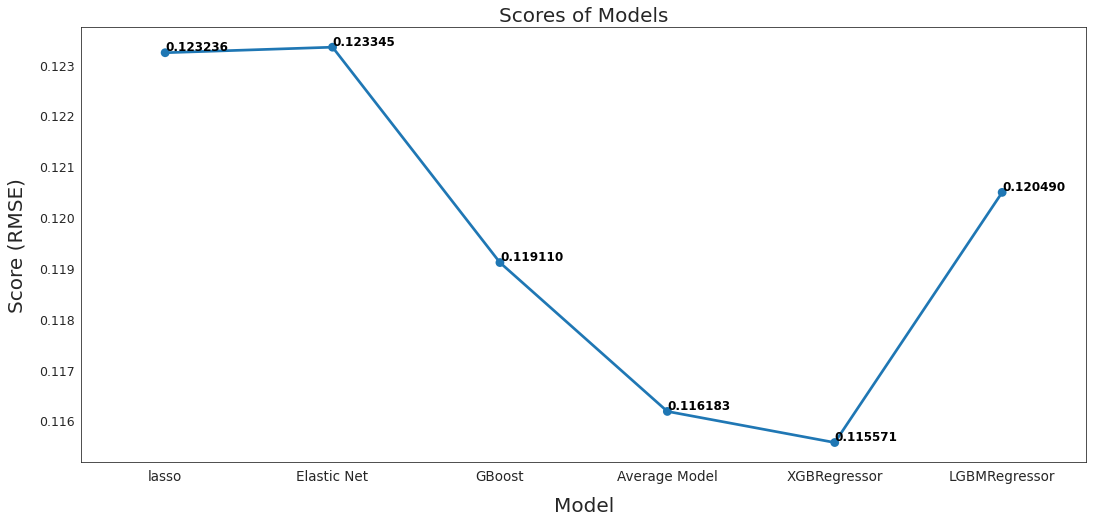

In [113]:
sns.set_style("white")
fig = plt.figure(figsize=(18, 8))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.00004, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()


In [114]:
averaged_pred = averaged_models.predict(X_test)
xgb_pred = model_xgb.predict(X_test)
lgb_pred = model_lgb.predict(X_test)

In [115]:
ensemble =  np.exp(averaged_pred*0.5 + xgb_pred*0.25 + lgb_pred*0.25)

In [116]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False) 